## Housekeeping Settings

In [4]:
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, seaborn as sns
wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/primaryBCell/'
out_path = os.path.join(wd, 'out_data', 'sc_preproc')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"

In [5]:
path_to_adata = os.path.join(wd, 'out_data','out_other_methods/adata_aggregated_gene.leiden_updated.h5ad')
adata = sc.read_h5ad(path_to_adata)
adata
# Data is already normalized and logged.....Since adata.X.A is float
# Another way to check np.sum(adata.layers['counts'].toarray(), axis=1) is similar to adata.obs["total_counts"]. Also log(1+x) is similar to adata.X
# Layers attribute has the original counts

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_myc_up', 'score_GC', 'score_PB', 'score_MBC_1', 'score_MBC_2', 'score_preGC', 'score_LZ_GC', 'score_DZ_GC', 'DNA_damage', 'LZ_vs_DZ_down', 'LZ_vs_DZ_up', 'Ag_presentation', 'BCR_signaling', 'topic7_peak_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p'

## Scanpy Preprocessing of scRNA
Typical steps which are followed in scRNA processing are:
1.   `Labeling genes which are not required`: Mitochondrial, Ribosomal, Hemoglobin
2.   `Looking for QC of Cells`: Here specifically we want to remove cells which have extremely high mitochondrial count
3.   `Filtering on Genes Expressed`: Getting rid of the genes which we don't want (Mitochondrial, Ribosomal, Hemoglobin)
4.   `Normalizing Gene Counts`: Due to different depth of the cells, we normalize the counts and then lake the log so that the values are in a decent range to be compared
5.   `Feature (here: genes) Selection`: We select top n genes (typically 3k) so that we can run various algorithms downstream. Genes which are specifically of interest should be added back since they might get dropped of due to the "top n genes" filtering
6.   `Dimentionality Reduction`: Not all dimentions (here: genes) are informative. hence run PCA to find the most variable n dimensions.
7.   `Downstream Analysis`: UMAP Plotting, Clustering, Cluster Identification, Expression of certain genes in clusters etc.

### `Labeling genes which are not required`

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # mitochondrial genes
adata.var["ribo"] = (adata.var_names.str.startswith(("Rps", "Rpl")) | adata.var_names.str.endswith(("Rps", "Rpl","Rik"))) # ribosomal genes

### `Looking for QC of Cells`

Number of cells before filtering of low quality cells: 32418


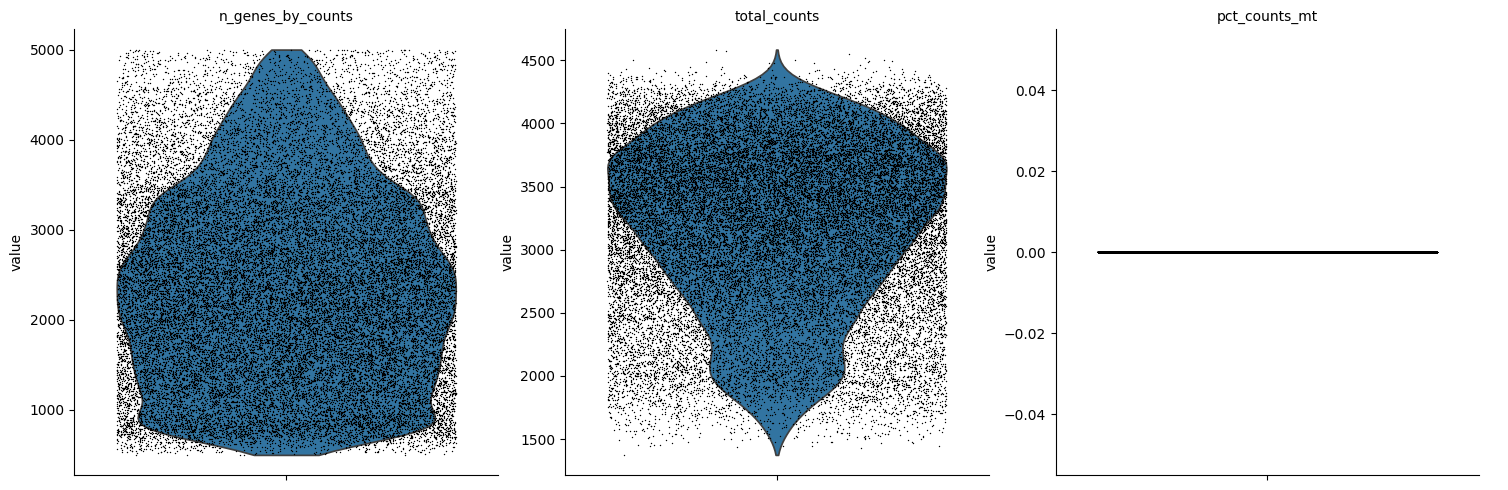

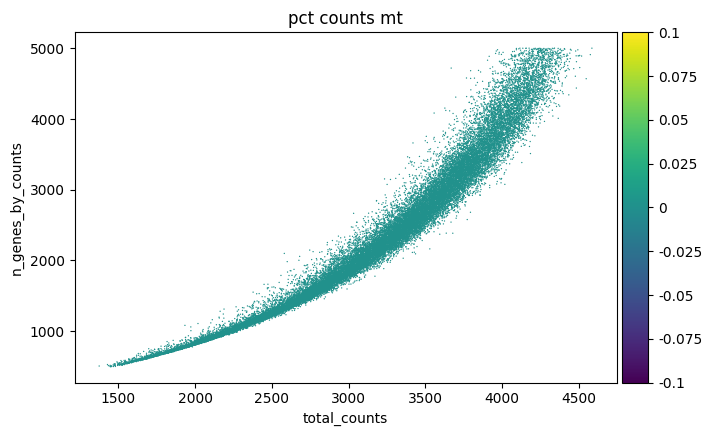

In [7]:
print(f"Number of cells before filtering of low quality cells: {adata.n_obs}")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True, log1p=True)
# the number of genes expressed in the count matrix, the total counts per cell, and the percentage of counts in mitochondrial genes
sc.pl.violin(adata,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.4,multi_panel=True, save="_qc_metrics_violin.png")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_qc_metrics_scatter.png")

### `Cleaning up cells which are not needed/ low QC`
Removing outliers : MAD (median absolute deviations)

In [5]:
# NOT running since data is already cleaned
# def is_outlier(adata, metric: str, nmads: int):
#     M = adata.obs[metric]
#     median_abs_deviation = np.median(np.abs(M - np.median(M)))
#     outlier = (M < np.median(M) - nmads * median_abs_deviation) | (np.median(M) + nmads * median_abs_deviation < M)
#     return outlier

# adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", 5) | is_outlier(adata, "log1p_n_genes_by_counts", 5) | is_outlier(adata, "pct_counts_in_top_50_genes", 5))
# adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (adata.obs["pct_counts_mt"] > 8)
# adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

### `Filtering on Genes Expressed`

In [8]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[:,(~adata.var['mt'] & ~adata.var['ribo'])] # Filter mitochondrial, linc, ribosomal, haemoglobin genes

#### Checking post QC

Number of cells after filtering of low quality cells: 32418


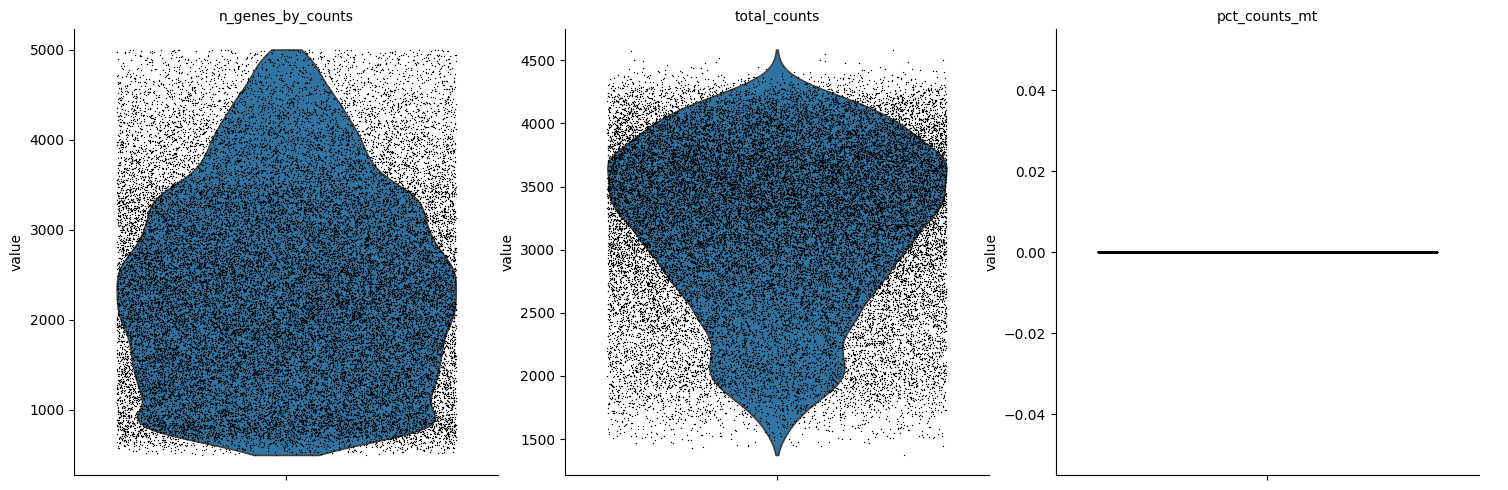

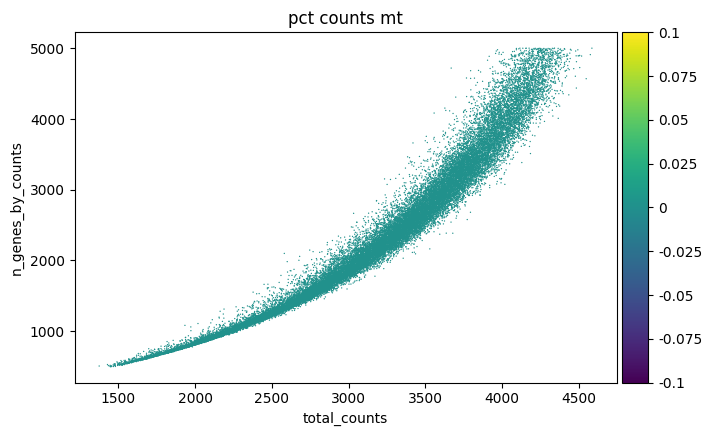

In [9]:
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
# the number of genes expressed in the count matrix, the total counts per cell, and the percentage of counts in mitochondrial genes
sc.pl.violin(adata,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.4,multi_panel=True, save="_qc_metrics_violin_filtered.png")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", save="_qc_metrics_scatter_filtered.png")

### `Normalizing Gene Counts`

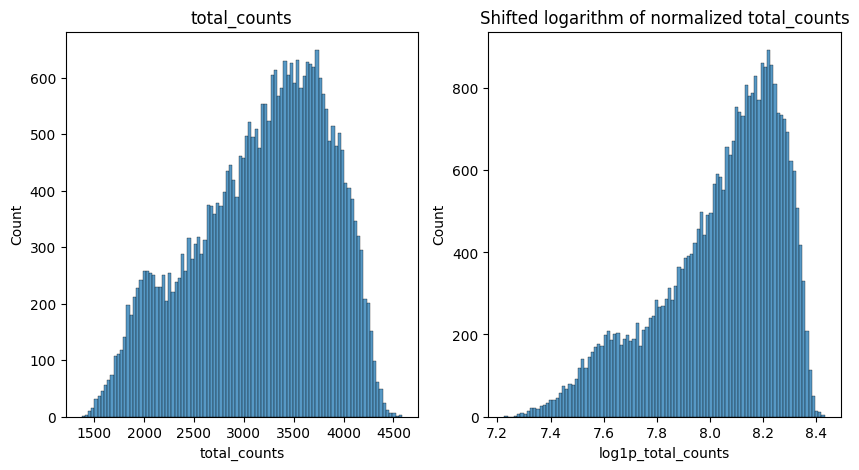

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("total_counts")
adata.layers["counts"] = adata.X.copy() # Saving the actual counts in different layer. often not useful due to variability in sequencing depth and other technical biases.
sc.pp.normalize_per_cell(adata, key_n_counts='total_counts') # Normalizing to median total counts
sc.pp.log1p(adata) # Taking log of the values
sns.histplot(adata.obs["log1p_total_counts"], bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm of normalized total_counts")
adata.raw = adata # store the log normalized data
plt.savefig(os.path.join(sc.settings.figdir, "total_counts.png"))

### `Feature (here: genes) Selection`

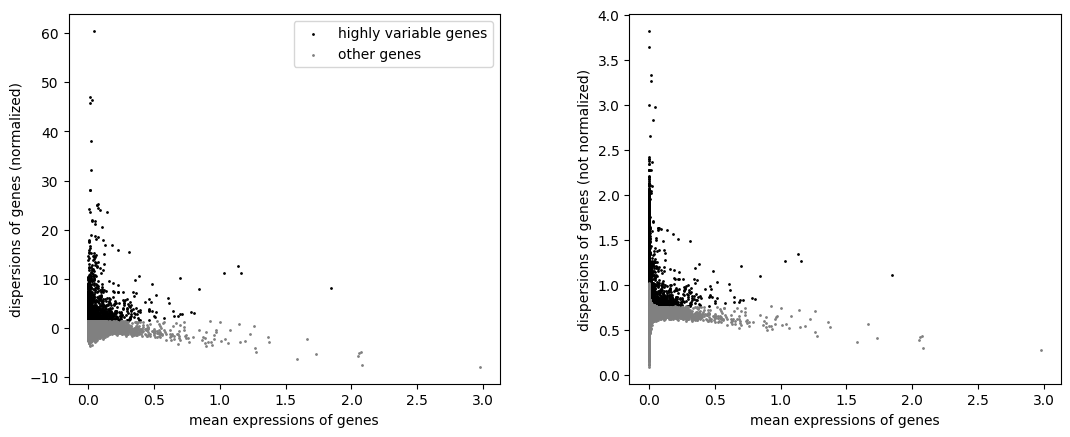

In [10]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger',n_top_genes=3000) # Select top 3000 highly-variable genes based on the normalized counts
sc.pl.highly_variable_genes(adata, save="_highly_variable_genes.png")

In [26]:
import glob, pickle
# read SLIDE data
feature_files = glob.glob(os.path.join(wd, 'out_data', 'out_other_methods', 'out4_0.26_1_out', '*feature_list*'))
feature_data = [pd.read_csv(file, sep='\t', header = 0) for file in feature_files]
feature_data = pd.concat(feature_data)
slide_features = set(feature_data['names'])
# read MIRA data
with open(os.path.join(wd, 'out_data', 'out_other_methods/TF_dict_MIRA_95pct.pkl'),'rb') as f:
    TF_to_TG_dictionary = pickle.load(f)
hvf_genes_mira = set([tg for values_list in TF_to_TG_dictionary.values() for tg in values_list])

In [27]:
# MODIFY FILTERED_GENES TO ADD GENES OF INTEREST
# # Overriding the bool_list to include TF of interest
# gene_list = ['Cma1', 'Foxp3', 'Cd3e', 'Cd8a', 'Cd3d', 'Cd3e', 'Trgv1', 'Trdv1']
# for gene in gene_list:
#     try:
#         if adata.var['highly_variable'][gene] == False :
#             adata.var['highly_variable'][gene]== True
#     except ValueError:
#         print(f"{gene} not in the list")
#         continue

# For this case just filtering the hvf+slide features
genes_of_interest = hvf_genes_mira.union(slide_features)
# Subset the genes
# adata = adata[:, adata.var.highly_variable]
adata = adata[:, adata.var_names.isin(genes_of_interest)]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

### `Dimentionality Reduction`

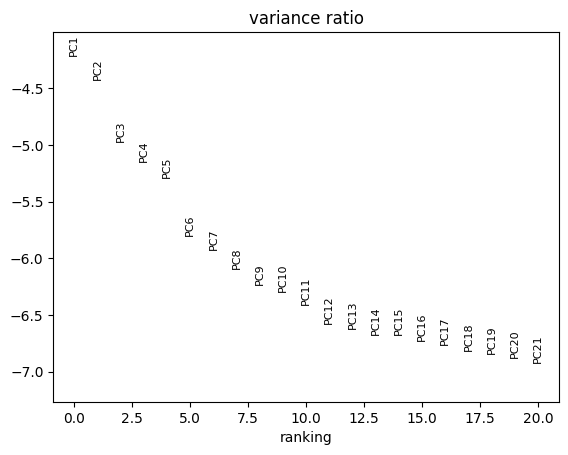

In [28]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
sc.pp.neighbors(adata)

### `Downstream Analysis`

#### Cluster and Plot in reduced dimensions

In [30]:
adata

AnnData object with n_obs × n_vars = 32418 × 2572
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_myc_up', 'score_GC', 'score_PB', 'score_MBC_1', 'score_MBC_2', 'score_preGC', 'score_LZ_GC', 'score_DZ_GC', 'DNA_damage', 'LZ_vs_DZ_down', 'LZ_vs_DZ_up', 'Ag_presentation', 'BCR_signaling', 'topic7_peak_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_mt', 'total_counts

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


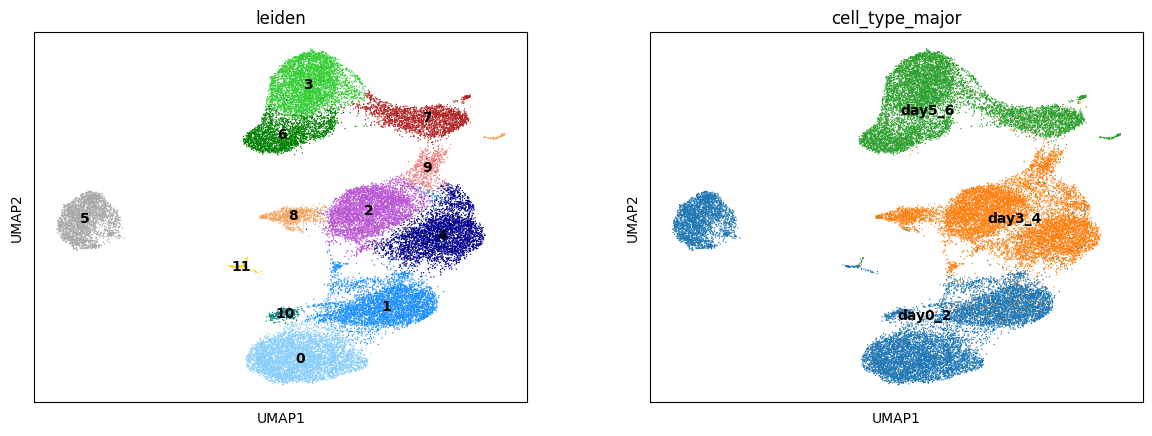

In [31]:
# Already clustered anndata
# sc.tl.umap(adata, random_state=42, min_dist=1, spread=1)
# sc.tl.leiden(adata, key_added=f"leiden", resolution=0.50)
sc.pl.umap(adata, color=["leiden", "cell_type_major"], legend_loc="on data", save="_leiden_umap.png")

#### Get gene groups for each cluster

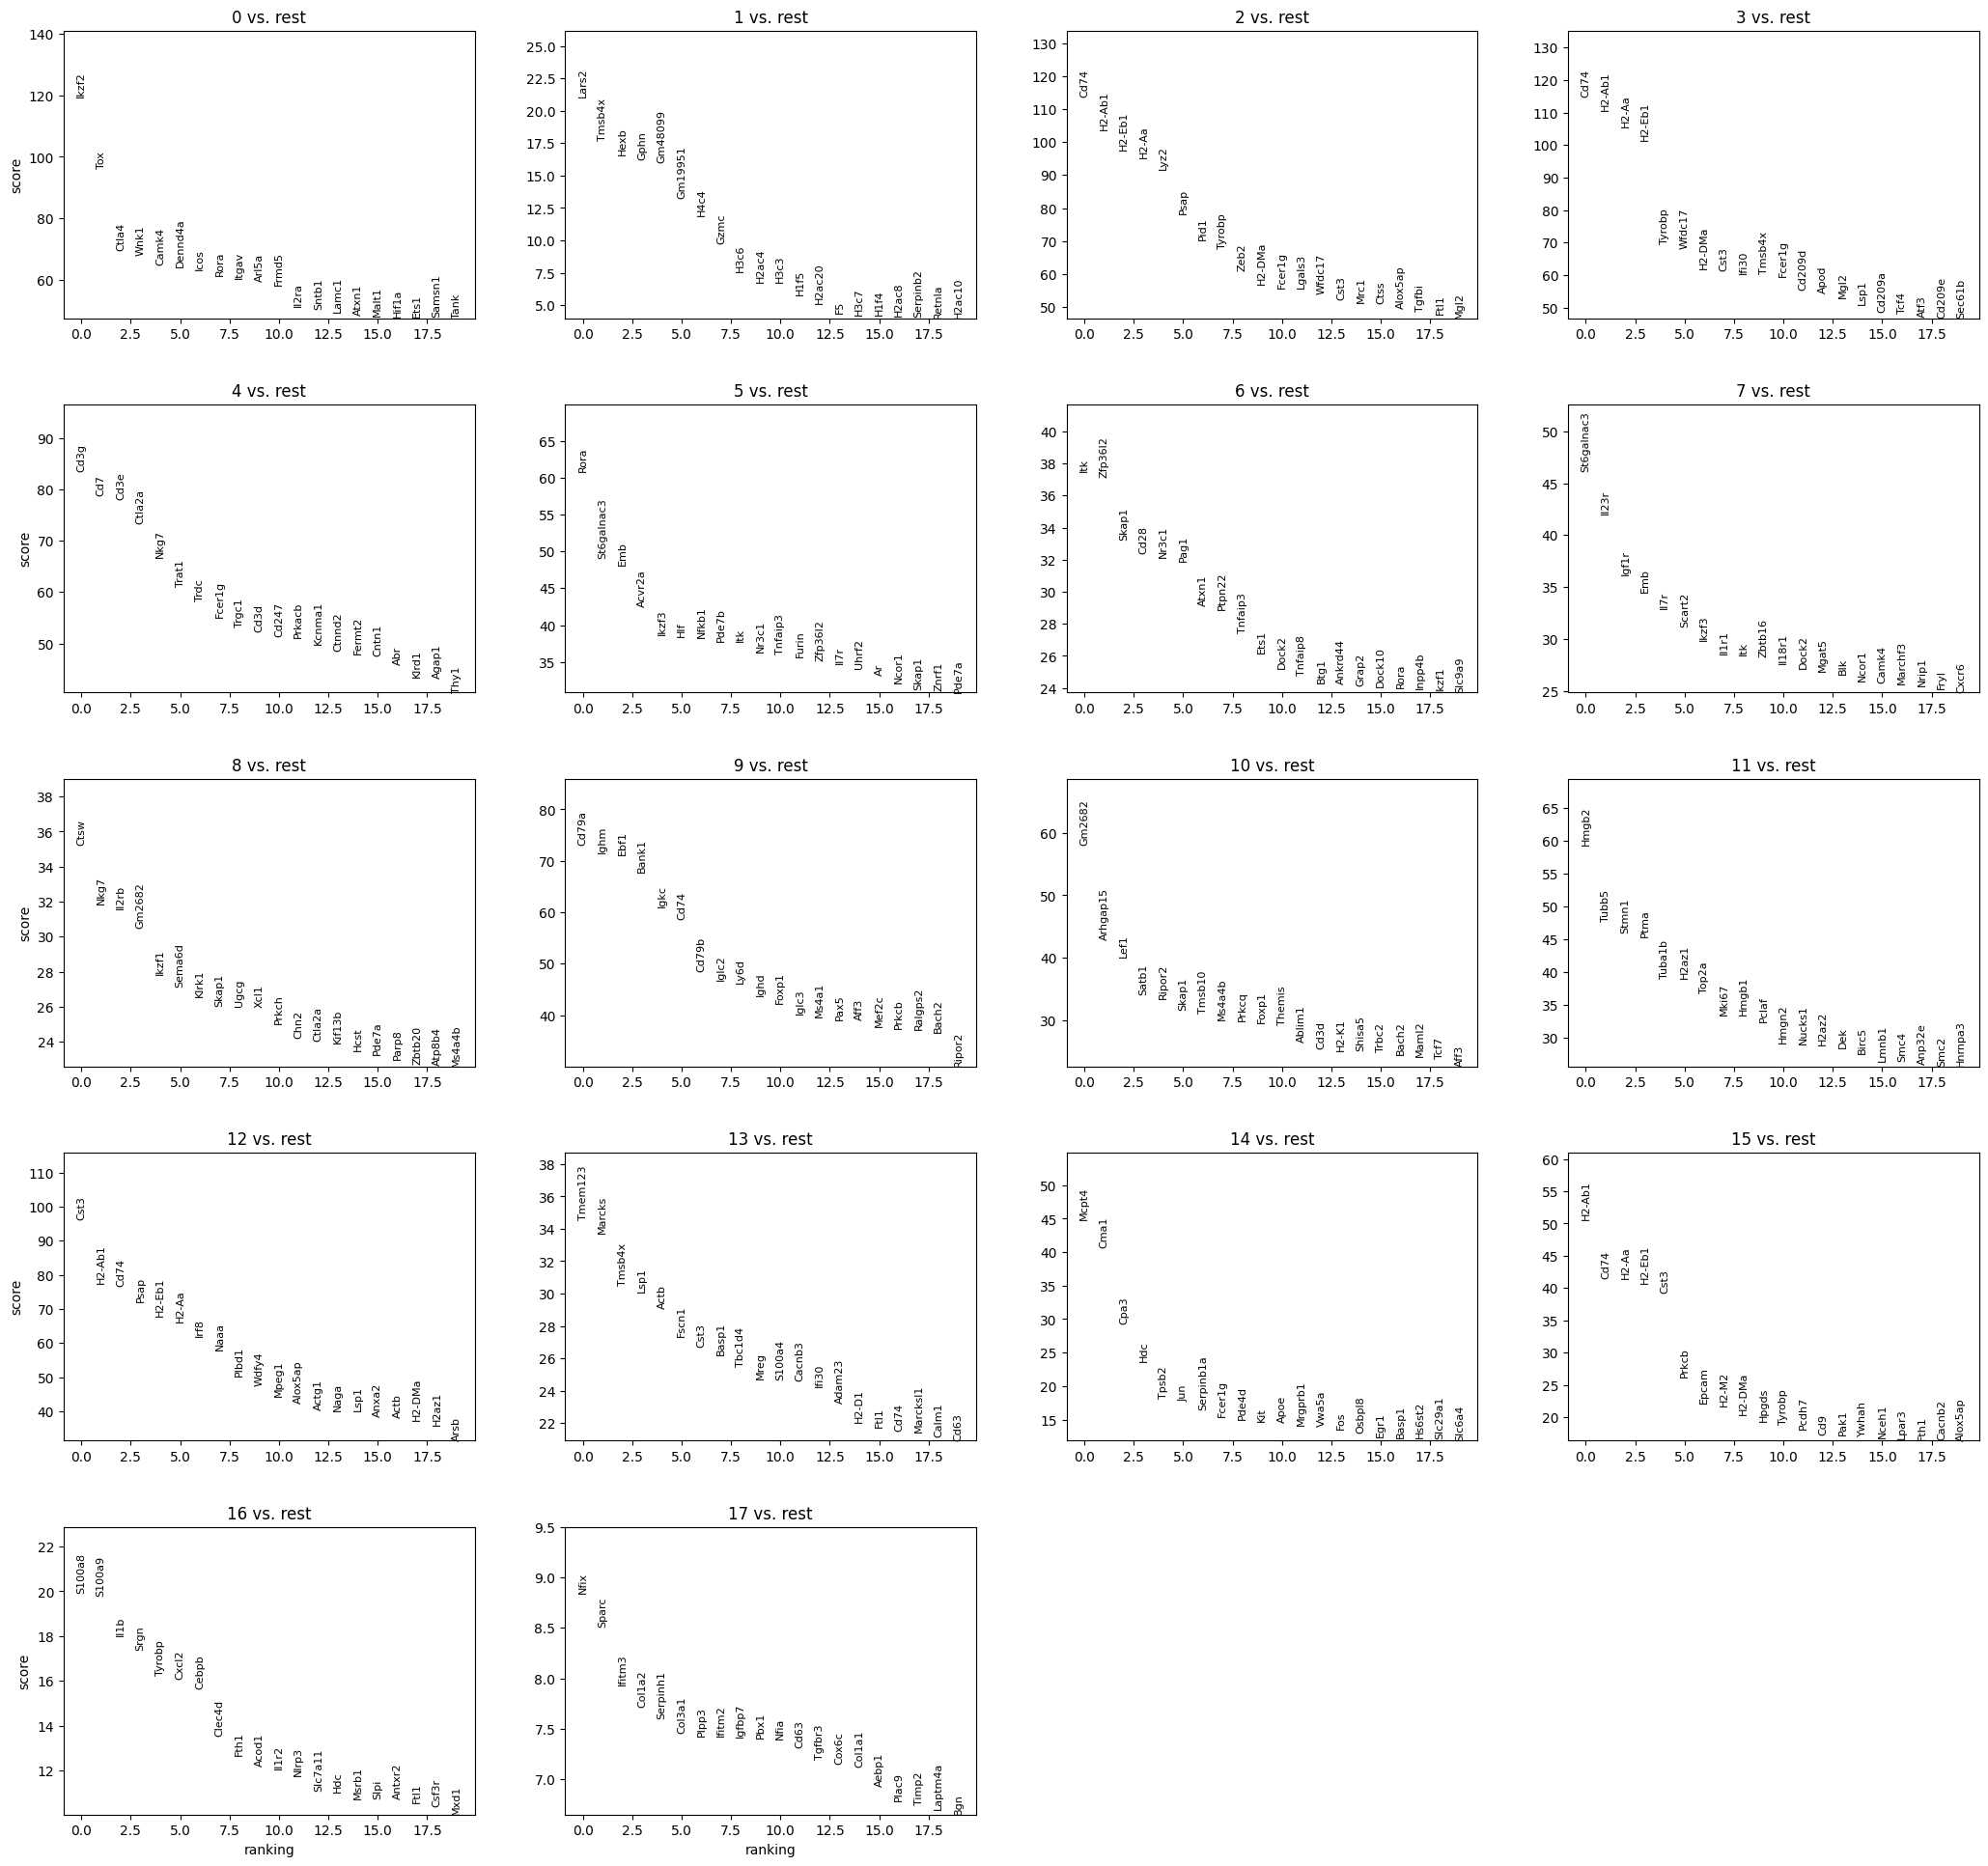

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


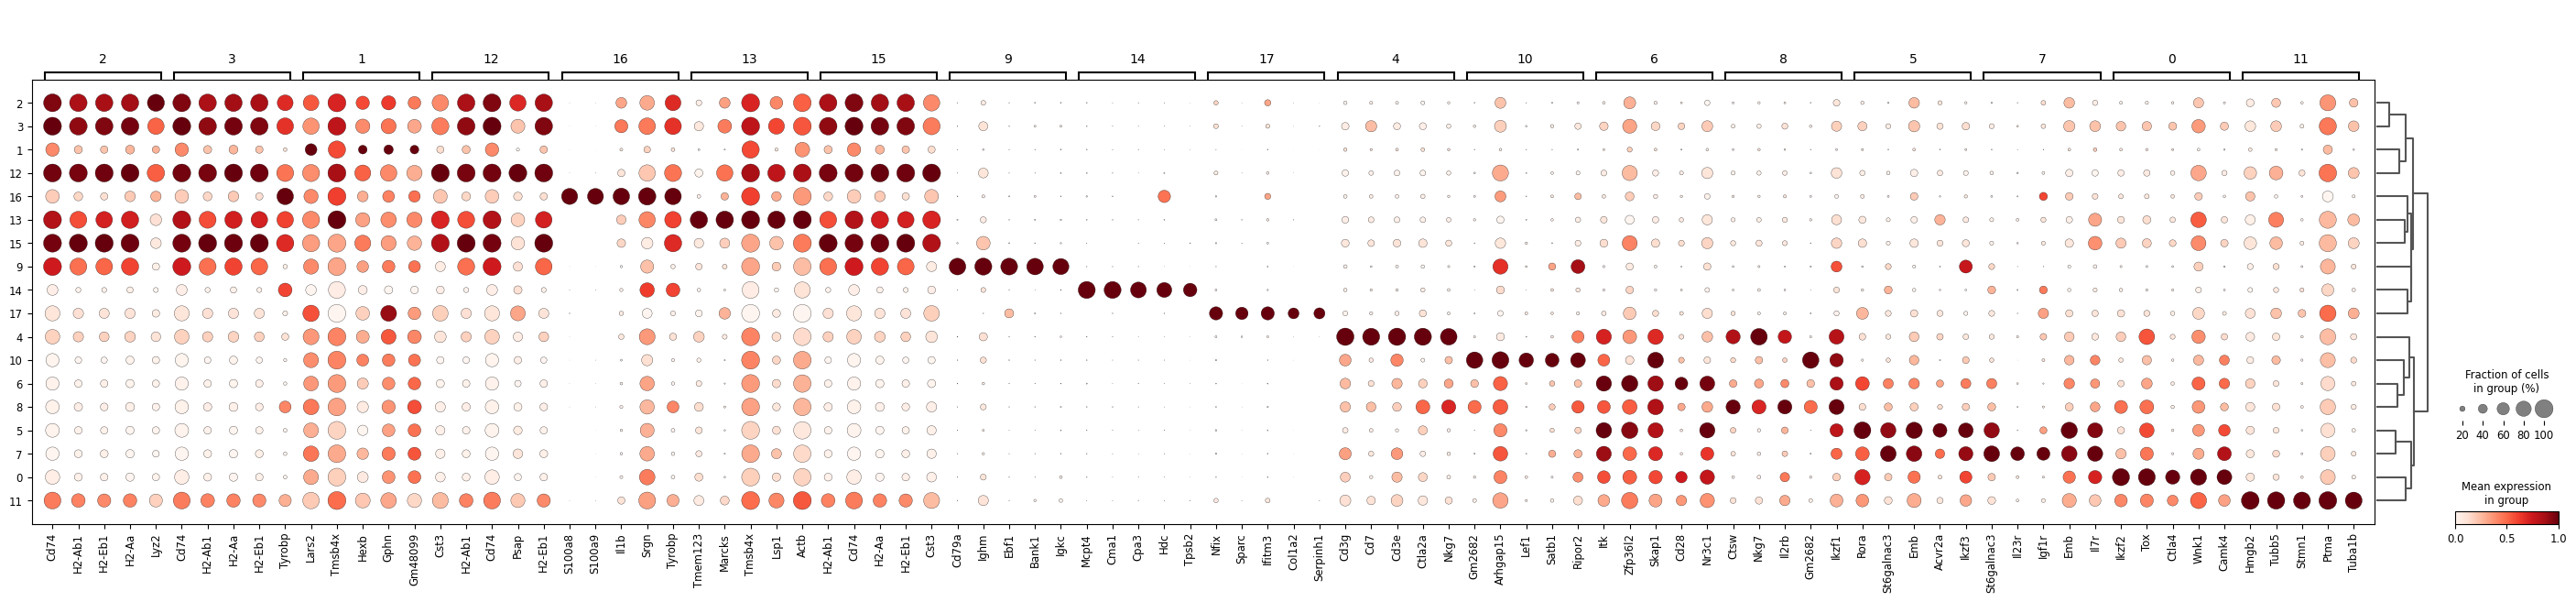

In [14]:
# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')  # You can choose other methods like 'wilcoxon', 'logreg'
# sc.tl.dendrogram(adata, groupby="leiden")
# sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, save="_rank_genes_groups.png")
# sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=5, save="_rank_genes_groups_dotplot.png")
# sc.get.rank_genes_groups_df(adata,group = None).to_csv(f'{out_path}/out_files/deg_rank_genes_groups.csv')

#### Cluster specific marker gene expression display

/ocean/projects/cis240075p/skeshari/.conda/envs/celloracle_env/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


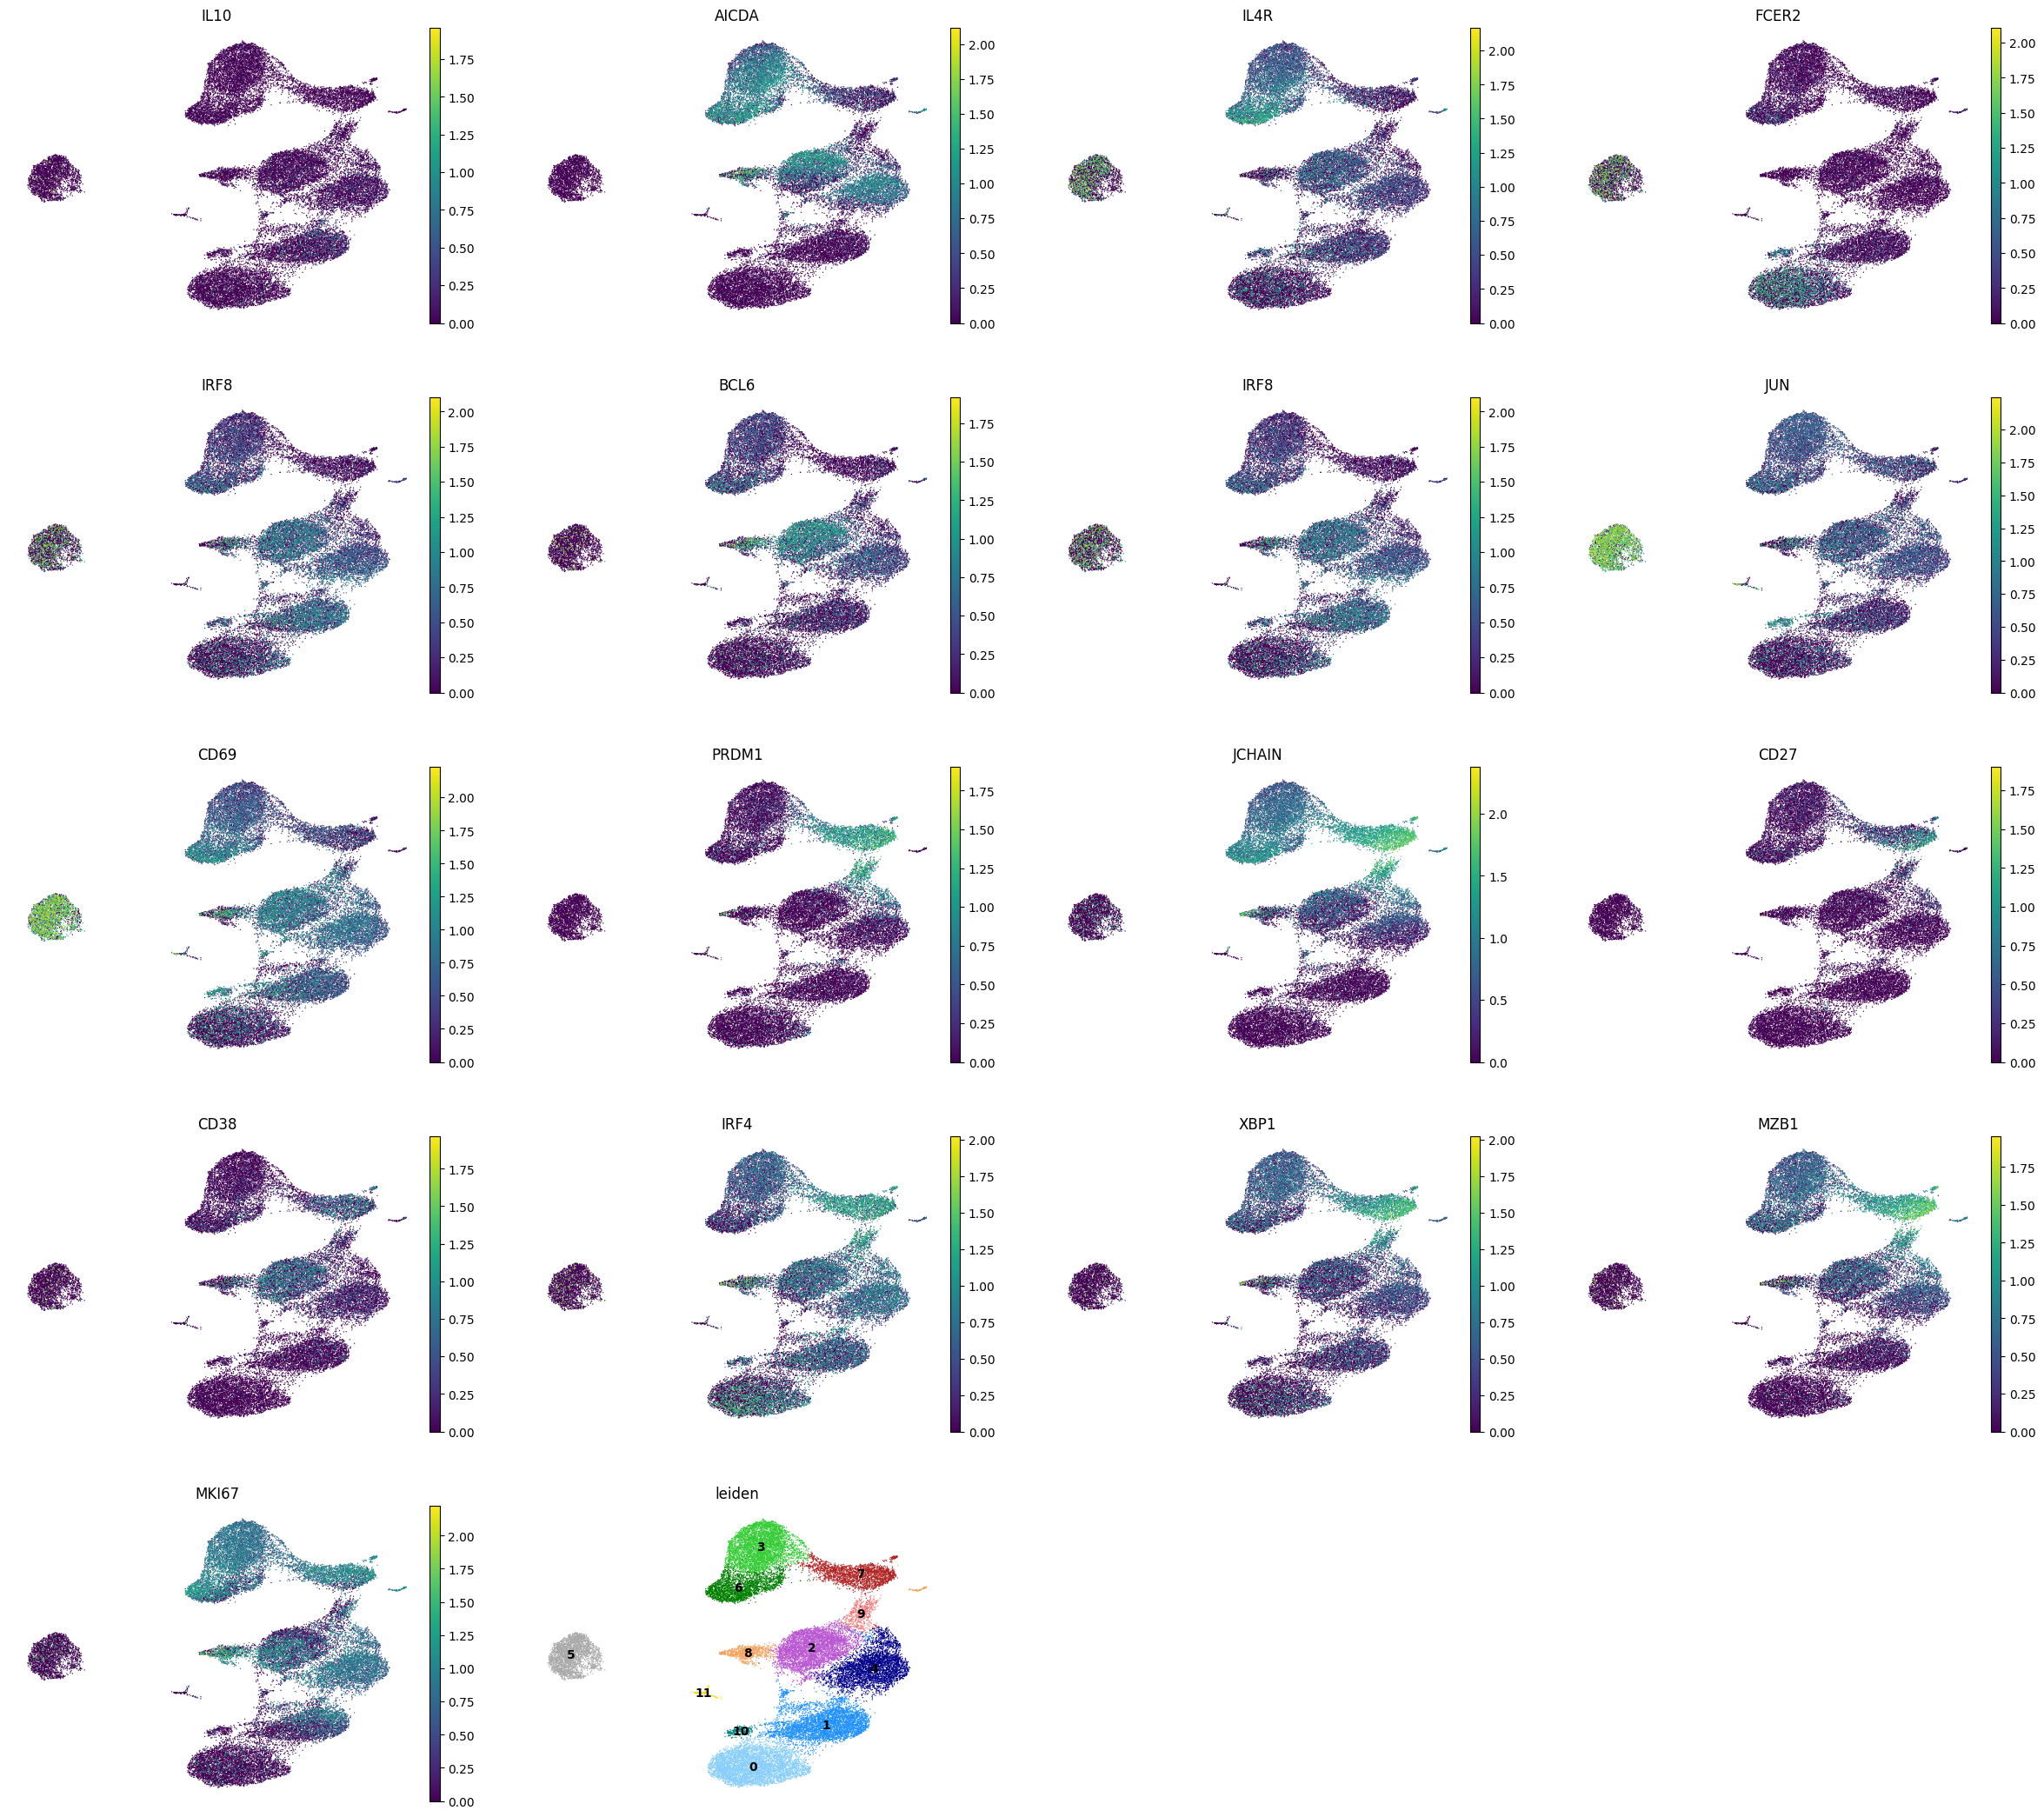

In [32]:
names = ['IL10', 'AICDA', 'IL4R', 'FCER2', 'IRF8', 'BCL6', 'IRF8', 'JUN', 'CD69', 'PRDM1', 'JCHAIN', 'CD27', 'CD38', 'IRF4', 'XBP1', 'MZB1', 'MKI67'] # BCell markers from literature
sc.pl.umap(adata,color=[*names,"leiden"],legend_loc="on data",frameon=False, save="_umap_genes.png")

#### Save anndata

In [33]:
adata.write(f'{out_path}/out_files/nick_sc_processed.h5ad')